In [1]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [4]:
!kaggle datasets download -d thanakomsn/glove6b300dtxt

Dataset URL: https://www.kaggle.com/datasets/thanakomsn/glove6b300dtxt
License(s): DbCL-1.0
 94% 361M/386M [00:02<00:00, 134MB/s]
100% 386M/386M [00:02<00:00, 135MB/s]


In [5]:
import zipfile
zip_ref = zipfile.ZipFile('/content/glove6b300dtxt.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

#Import some important libaries

In [6]:
from keras.layers import Dense, Input, LSTM, Dropout, Bidirectional
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import BatchNormalization
from keras.layers import Embedding
from keras.callbacks import TensorBoard
from keras.models import load_model
from keras.models import Model
from keras.utils import plot_model
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.preprocessing import text
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding, LSTM, Bidirectional
from keras.layers import Conv1D, Flatten
from keras.preprocessing import text
from keras.models import Sequential,Model
from keras.layers import Dense ,Activation,MaxPool1D,Conv1D,Flatten,Dropout,Activation,Dropout,Input,Lambda,concatenate
import csv
import pandas as pd
import numpy as np
from keras.preprocessing import text as keras_text, sequence as keras_seq
from operator import itemgetter
import time
import gc
import os
import re
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#Reading Dataset

In [7]:
# Sample data
new_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/qura_question_pair.csv")
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [8]:
new_df = new_df.dropna()
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 404287 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404287 non-null  int64 
 1   qid1          404287 non-null  int64 
 2   qid2          404287 non-null  int64 
 3   question1     404287 non-null  object
 4   question2     404287 non-null  object
 5   is_duplicate  404287 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 21.6+ MB


In [9]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 404287 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404287 non-null  int64 
 1   qid1          404287 non-null  int64 
 2   qid2          404287 non-null  int64 
 3   question1     404287 non-null  object
 4   question2     404287 non-null  object
 5   is_duplicate  404287 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 21.6+ MB


#Preprocess question pair

In [10]:
from bs4 import BeautifulSoup
import re

In [11]:
def preprocess(q):

    q = str(q).lower().strip()

    # Replace certain special characters with their string equivalents
    q = q.replace('%', ' percent')
    q = q.replace('$', ' dollar ')
    q = q.replace('₹', ' rupee ')
    q = q.replace('€', ' euro ')
    q = q.replace('@', ' at ')

    # The pattern '[math]' appears around 900 times in the whole dataset.
    q = q.replace('[math]', '')

    # Replacing some numbers with string equivalents (not perfect, can be done better to account for more cases)
    q = q.replace(',000,000,000 ', 'b ')
    q = q.replace(',000,000 ', 'm ')
    q = q.replace(',000 ', 'k ')
    q = re.sub(r'([0-9]+)000000000', r'\1b', q)
    q = re.sub(r'([0-9]+)000000', r'\1m', q)
    q = re.sub(r'([0-9]+)000', r'\1k', q)

    # Decontracting words
    # https://en.wikipedia.org/wiki/Wikipedia%3aList_of_English_contractions
    # https://stackoverflow.com/a/19794953
    contractions = {
    "ain't": "am not",
    "aren't": "are not",
    "can't": "can not",
    "can't've": "can not have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }

    q_decontracted = []

    for word in q.split():
        if word in contractions:
            word = contractions[word]

        q_decontracted.append(word)

    q = ' '.join(q_decontracted)
    q = q.replace("'ve", " have")
    q = q.replace("n't", " not")
    q = q.replace("'re", " are")
    q = q.replace("'ll", " will")

    # Removing HTML tags
    q = BeautifulSoup(q)
    q = q.get_text()
    # Removing HTML tags
    q = BeautifulSoup(q)
    q = q.get_text()

    # Remove punctuations
    pattern = re.compile('\W')
    q = re.sub(pattern, ' ', q).strip()


    return q

In [12]:
new_df['question1'] = new_df['question1'].apply(preprocess)
new_df['question2'] = new_df['question2'].apply(preprocess)

<ipython-input-11-da7cec07d695>:161: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  q = BeautifulSoup(q)
<ipython-input-11-da7cec07d695>:164: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  q = BeautifulSoup(q)
<ipython-input-11-da7cec07d695>:161: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  q = BeautifulSoup(q)
<ipython-input-11-da7cec07d695>:164: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  q = BeautifulSoup(q)


#Storing question_1 and question_2 in different variable

In [13]:
question_one= new_df['question1'].astype(str)
print(question_one.head())

0    what is the step by step guide to invest in sh...
1    what is the story of kohinoor  koh i noor  dia...
2    how can i increase the speed of my internet co...
3    why am i mentally very lonely  how can i solve it
4    which one dissolve in water quikly sugar  salt...
Name: question1, dtype: object


In [14]:
question_two= new_df['question2'].astype(str)
print(question_two.head())

0    what is the step by step guide to invest in sh...
1    what would happen if the indian government sto...
2    how can internet speed be increased by hacking...
3    find the remainder when 23  24   math  is divi...
4               which fish would survive in salt water
Name: question2, dtype: object


#Fitting text on a single tokenized object

In [15]:
from keras.preprocessing.text import Tokenizer
tok_all = Tokenizer(filters='!"#$%&\'()*+,-./:;<=>?@[\]^_`{|}~', lower=True, char_level = False)
tok_all.fit_on_texts(question_one+question_two)

In [16]:
vocabulary_all=len(tok_all.word_counts)
print(vocabulary_all)

176151


#Encoding every question

In [17]:
#Encoding question 1
encoded_q1=tok_all.texts_to_sequences(question_one)
print(question_one[0])
encoded_q1[0]

what is the step by step guide to invest in share market in india


[7, 2, 1, 1195, 57, 1195, 2601, 5, 538, 6, 734, 429, 6, 46]

In [18]:
#Encoding question 2
encoded_q2=tok_all.texts_to_sequences(question_two)
print(question_two[0])
encoded_q2[0]

what is the step by step guide to invest in share market


[7, 2, 1, 1195, 57, 1195, 2601, 5, 538, 6, 734, 429]

#Pre padding the encoded sequences

In [19]:
#####Padding encoded sequence of words of question_1
from keras.preprocessing import sequence
max_length=100
padded_docs_q1 = sequence.pad_sequences(encoded_q1, maxlen=max_length, padding='pre')

In [20]:
#####Padding encoded sequence of words of question_2
from keras.preprocessing import sequence
max_length=100
padded_docs_q2 = sequence.pad_sequences(encoded_q2, maxlen=max_length, padding='pre')

#Reading Embedding Vector from Glove

In [21]:
embeddings_index = {}
f = open('/content/glove.6B.300d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [22]:
#create embedding matrix

embedding_matrix = np.zeros((vocabulary_all+1, 300))
for word, i in tok_all.word_index.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		# words not found in embedding index will be all-zeros.
		embedding_matrix[i] = embedding_vector

#Initialization of some variables

In [23]:
rate_drop_lstm = 0.17
number_dense_units = 64
activation_function = 'relu'
rate_drop_dense = 0.25
validation_split_ratio = 0.3

#Add a feature to the data frame

In [24]:
def commonWords():
   # leak data
   length_features = [[len(set(x1)), len(set(x2)), len(set(x1).intersection(x2))] for x1, x2 in zip(encoded_q1, encoded_q2)]
   length_features = np.array(length_features)
   return length_features
length_features= commonWords()

In [25]:
length_features.shape

(404287, 3)

In [26]:
#Convert labels from 1d array into 2d array
import numpy as np
from keras.utils import to_categorical
label_twoDimension = to_categorical(new_df['is_duplicate'], num_classes=2)

#train test split

In [27]:
from sklearn.model_selection import train_test_split
text_train_q1, text_test_q1, text_train_q2, text_test_q2, length_features_train, length_features_test,label_train, label_test = train_test_split(padded_docs_q1, padded_docs_q2, length_features, label_twoDimension, test_size=0.3, random_state=42)


In [28]:
print('shape of text_train_q1   ', text_train_q1.shape)
print('shape of text_test_q1   ', text_test_q1.shape)
print('shape of text_train_q2   ', text_train_q2.shape)
print('shape of text_test_q2   ', text_test_q2.shape)
print('shape of length_features_train  ', length_features_train.shape)
print('shape of tlength_features_test   ', length_features_test.shape)
print('shape of label_train   ', label_train.shape)
print('shape of label_test   ', label_test.shape)

shape of text_train_q1    (283000, 100)
shape of text_test_q1    (121287, 100)
shape of text_train_q2    (283000, 100)
shape of text_test_q2    (121287, 100)
shape of length_features_train   (283000, 3)
shape of tlength_features_test    (121287, 3)
shape of label_train    (283000, 2)
shape of label_test    (121287, 2)


In [29]:
# Adding Embedding layer
embedding_layer = (Embedding(vocabulary_all+1,300,weights=[embedding_matrix], input_length=max_length, trainable=False))


# Creating LSTM Encoder
lstm_layer = Bidirectional(LSTM(64,  dropout=rate_drop_lstm, recurrent_dropout=rate_drop_lstm))

# Creating LSTM Encoder layer for First Sentence
sequence_1_input = Input(shape=(max_length,), dtype='int32')
embedded_sequences_1 = embedding_layer(sequence_1_input)
x1 = lstm_layer(embedded_sequences_1)

# Creating LSTM Encoder layer for Second Sentence
sequence_2_input = Input(shape=(max_length,), dtype='int32')
embedded_sequences_2 = embedding_layer(sequence_2_input)
x2 = lstm_layer(embedded_sequences_2)

# Creating leaks input
wordLength_input = Input(shape=(length_features_train.shape[1],))
wordLength_dense = Dense(int(number_dense_units/2), activation=activation_function)(wordLength_input)

In [30]:
# Merging two LSTM encodes vectors from sentences to pass it to dense layer applying dropout and batch normalisation
merged = concatenate([x1, x2, wordLength_dense])
merged = BatchNormalization()(merged)
merged = Dropout(rate_drop_dense)(merged)
merged = Dense(number_dense_units, activation=activation_function)(merged)
merged = BatchNormalization()(merged)
merged = Dropout(rate_drop_dense)(merged)
preds = Dense(2, activation='sigmoid')(merged)

model = Model(inputs=[sequence_1_input, sequence_2_input, wordLength_input], outputs=preds)
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['acc'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 100, 300)             5284560   ['input_1[0][0]',             
                                                          0          'input_2[0][0]']             
                                                                                                  
 input_3 (InputLayer)        [(None, 3)]                  0         []                        

In [32]:
#Visualization of model
plot_model(model, to_file='model_lstm2_3rd_feature.png')


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [33]:
#callbacks defined
from keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint

earlystopper = EarlyStopping(patience=8, verbose=1)
checkpointer = ModelCheckpoint(filepath = 'lstm_model_three_.{epoch:02d}-{val_loss:.6f}.hdf5',verbose=1,save_best_only=True,
                               save_weights_only = True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=2, min_lr=0.00001, verbose=1)

In [34]:
#Train the model
history = model.fit([text_train_q1, text_train_q2, length_features_train], label_train,
                    validation_data=([text_test_q1, text_test_q2, length_features_test], label_test),
                    epochs=200, batch_size= 1024,callbacks=[earlystopper, checkpointer, reduce_lr],verbose=1)

Epoch 1/200
277/277 [==============================] - ETA: 0s - loss: 0.5485 - acc: 0.7176
Epoch 1: val_loss improved from inf to 0.46933, saving model to lstm_model_three_.01-0.469327.hdf5
277/277 [==============================] - 296s 1s/step - loss: 0.5485 - acc: 0.7176 - val_loss: 0.4693 - val_acc: 0.7565 - lr: 0.0010
Epoch 2/200
277/277 [==============================] - ETA: 0s - loss: 0.4609 - acc: 0.7614
Epoch 2: val_loss improved from 0.46933 to 0.43793, saving model to lstm_model_three_.02-0.437932.hdf5
277/277 [==============================] - 277s 1s/step - loss: 0.4609 - acc: 0.7614 - val_loss: 0.4379 - val_acc: 0.7739 - lr: 0.0010
Epoch 3/200
277/277 [==============================] - ETA: 0s - loss: 0.4392 - acc: 0.7751
Epoch 3: val_loss improved from 0.43793 to 0.42022, saving model to lstm_model_three_.03-0.420216.hdf5
277/277 [==============================] - 278s 1s/step - loss: 0.4392 - acc: 0.7751 - val_loss: 0.4202 - val_acc: 0.7892 - lr: 0.0010
Epoch 4/200
27

In [35]:
min_val_loss = min(history.history["val_loss"])
min_train_loss = min(history.history["loss"])
max_val_acc = max(history.history["val_acc"])
max_train_acc = max(history.history["acc"])
print("min_train_loss=%g, min_val_loss=%g, max_train_acc=%g, max_val_acc=%g" % (min_train_loss,min_val_loss,max_train_acc,max_val_acc))


min_train_loss=0.323898, min_val_loss=0.357878, max_train_acc=0.849131, max_val_acc=0.831647


In [45]:
import numpy as np
x = np.argmax(history.history["val_acc"])
print(x)

39


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

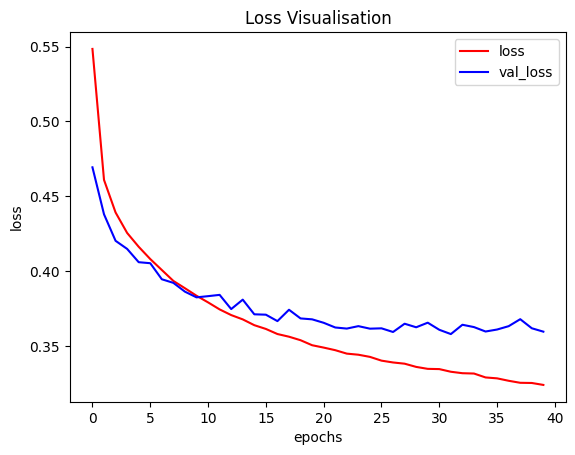

In [36]:
from matplotlib import pyplot as plt
plt.plot(history.history["loss"],color = 'red', label = 'loss')
plt.plot(history.history["val_loss"],color = 'blue', label = 'val_loss')
plt.title('Loss Visualisation')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.savefig('loss_siamese_lstm_3_with_3rd_feature.pdf',dpi=1000)

from google.colab import files
files.download('loss_siamese_lstm_3_with_3rd_feature.pdf')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

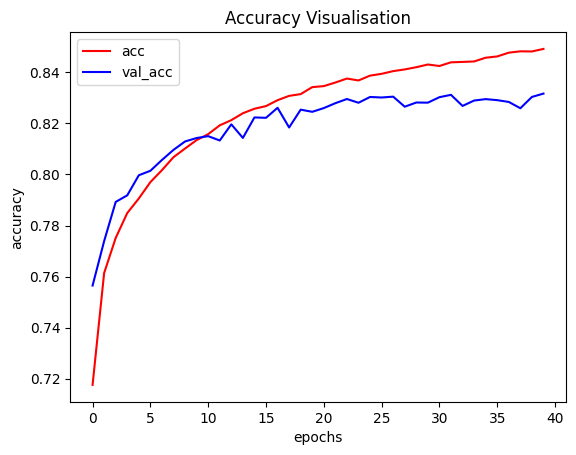

In [38]:
plt.plot(history.history["acc"],color = 'red', label = 'acc')
plt.plot(history.history["val_acc"],color = 'blue', label = 'val_acc')
plt.title('Accuracy Visualisation')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.savefig('acc_siamese_lstm_3_with_3rd_feature.pdf',dpi=1000)
files.download('acc_siamese_lstm_3_with_3rd_feature.pdf')

In [39]:
from keras.models import load_model
model.save('/content/lstm_model_three_.32-0.357878.hdf5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#Classification Report

In [40]:
model_predictions = model.predict([text_test_q1, text_test_q2, length_features_test])

3791/3791 [==============================] - 95s 25ms/step


In [41]:
predictions = np.zeros_like(model_predictions)
predictions[np.arange(len(model_predictions)), model_predictions.argmax(1)] = 1

In [42]:
from sklearn.metrics import classification_report
print(classification_report(label_test,predictions))

              precision    recall  f1-score   support

           0       0.89      0.83      0.86     76609
           1       0.74      0.83      0.78     44678

   micro avg       0.83      0.83      0.83    121287
   macro avg       0.82      0.83      0.82    121287
weighted avg       0.84      0.83      0.83    121287
 samples avg       0.83      0.83      0.83    121287



In [44]:
from sklearn.metrics import log_loss
log_loss_val= log_loss(label_test,model_predictions)
log_loss_val

0.35949713630163105